In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import orbit_dynamic
warnings.filterwarnings("ignore")

In [ ]:
initial_pos = [-1259.842691,6335.726319,-2024.004255]
initial_Q = [-0.615285,-0.645667,0.419724,0.168437]
initial_v = [-5.632442,-2.571912,-4.533970]
delta_time = 0.1
def get_C_bi(q):
  if q[3] < 0:
    q = -q
  q0, q1, q2, q3 = q
  Msi = np.array([[q3**2+q0**2-q1**2-q2**2, 2*q3*q2+2*q0*q1,     -2*q3*q1+2*q0*q2],
                  [-2*q3*q2+2*q0*q1,    q3**2-q0**2+q1**2-q2**2, 2*q3*q0+2*q1*q2],
                  [2*q3*q1+2*q0*q2,     -2*q3*q0+2*q1*q2,    q3**2-q0**2-q1**2+q2**2]])
  return Msi.T

def get_attitude_angle(q):
  q0, q1, q2, q3 = q
  phi = np.arcsin(2*(q0*q1+q2*q3))
  psi = -np.arctan2(2*(q1*q3-q0*q2), q0**2-q1**2-q2**2+q3**2)
  gamma = -np.arctan2(2*(-q0*q3+q1*q2), q0**2-q1**2+q2**2-q3**2)
  return np.array([phi,psi,gamma])

def skew_4(v):
  x,y,z = v
  return np.array([[0,-x,-y,-z],[x,0,z,y],[y,-z,0,x],[z,-y,-x,0]]) #???return np.array([[0,-x,-y,-z],[x,0,z,-y],[y,-z,0,x],[z,y,-x,0]])

def picard(Q, delta_A): # 毕卡求解
  delta_theta = skew_4(delta_A)
  delta_A_mod = np.linalg.norm(delta_A)
  update_Q = np.eye(4)*np.cos(delta_A_mod/2) + delta_theta*np.sin(delta_A_mod/2)/delta_A_mod
  return update_Q @ Q

def j2_perturbation_acceleration(r, mu=3.986004418e14, J2=1.08262668e-3, Re=6378137):
    rx, ry, rz = r
    r_norm = np.linalg.norm(r)  # 位置矢量模
    # 计算公共项
    re_over_r = Re / r_norm
    re_over_r_sq = re_over_r**2
    rz_over_r = rz / r_norm
    rz_over_r_sq = rz_over_r**2
    # J2修正因子（注意x/y与z分量的差异）
    factor_xy = 1 + (3/2) * J2 * re_over_r_sq * (1 - 5 * rz_over_r_sq)
    factor_z  = 1 + (3/2) * J2 * re_over_r_sq * (3 - 5 * rz_over_r_sq)
    #加速度计算
    scale = -mu/(r_norm**3)
    ax = scale * factor_xy * rx
    ay = scale * factor_xy * ry
    az = scale * factor_z  * rz
    
    return np.array([ax, ay, az])

In [4]:
imu_data = pd.read_csv('imudata.csv')
imu_data['time'] = pd.to_datetime(imu_data['time'])
sensor_data = pd.read_csv('data/mysenior_sensor_data_output.csv')
sensor_data['Time (UTCG)'] = pd.to_datetime(sensor_data['Time (UTCG)'])
time_list = sensor_data['Time (UTCG)'].tolist()
visible_star = pd.read_csv('log_data.csv')
visible_star['time'] = pd.to_datetime(visible_star['time'])
visible_star = visible_star[visible_star['category'] == 'star']
visible_star = visible_star.reset_index(drop=True)
# visible_debris = pd.read_csv('visible_debris.csv')
# visible_debris['time'] = pd.to_datetime(visible_debris['time'])
visible_debris = pd.read_csv('log_data.csv')
visible_debris['time'] = pd.to_datetime(visible_debris['time'])
visible_debris = visible_debris[visible_debris['category'] == 'debris']
visible_debris = visible_debris.reset_index(drop=True)


In [ ]:
# 惯导求解
last_Q = initial_Q
last_pos = initial_pos
last_v = initial_v
Q_log = [last_Q]
pos_log = [initial_pos]
v_log = [initial_v]
for i in range(len(imu_data)):
  C_bi = get_C_bi(last_Q)
  wb = np.array(imu_data.iloc[i][4:]).astype(float) #陀螺仪输出的角速度
  delta_A = C_bi.T @np.deg2rad(wb*0.1) # 角增量
  # print(delta_A,np.deg2rad(C_bi.T@wb))
  last_Q = picard(last_Q, delta_A)#毕卡
  # print(last_Q,sensor_data.iloc[i][['q1','q2','q3','q4']].values)
  Q_log.append(last_Q)
  acc = np.array(imu_data.iloc[i][1:4]).astype(float) #加速度
  acc_i = C_bi.T @ acc #惯性系下的加速度，约等于0（没有主动机动，自由落体）
  gi = j2_perturbation_acceleration(np.array(last_pos)*1000) # 当前位置的引力加速度
  acc_i = (acc_i + gi)/1000
  last_v = last_v + acc_i*delta_time
  last_pos = last_pos + last_v*delta_time + 0.5*acc_i*delta_time**2
  pos_log.append(last_pos)
  v_log.append(last_v)


In [6]:
attitude_log = []
true_attitude_log = []
for i in range(len(Q_log)):
  q = np.array(Q_log[i])
  phi, theta, psi = get_attitude_angle(q)
  attitude_log.append([phi, theta, psi])
  q = sensor_data.iloc[i][['q1','q2','q3','q4']].values
  phi, theta, psi = get_attitude_angle(q)
  true_attitude_log.append([phi, theta, psi])
attitude_log = np.array(attitude_log)
true_attitude_log = np.array(true_attitude_log)
attitude_log = np.rad2deg(attitude_log)
true_attitude_log = np.rad2deg(true_attitude_log)
print(len(attitude_log), len(true_attitude_log),len(Q_log), len(pos_log), len(v_log))


6000 6000 6000 6000 6000


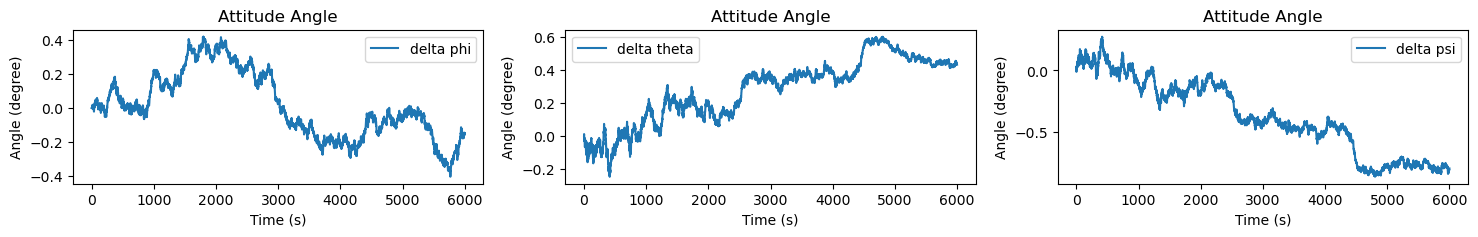

In [7]:
# 画图
plt.figure(figsize=(18,2))
plt.subplot(131)
plt.plot(attitude_log[:,0]-true_attitude_log[:,0], label='delta phi')
plt.title('Attitude Angle')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degree)')
plt.legend()
plt.subplot(132)
plt.plot(attitude_log[:,1]-true_attitude_log[:,1], label='delta theta')
plt.title('Attitude Angle')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degree)')
plt.legend()
plt.subplot(133)
plt.plot(attitude_log[:,2]-true_attitude_log[:,2], label='delta psi')
plt.title('Attitude Angle')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degree)')
plt.legend()

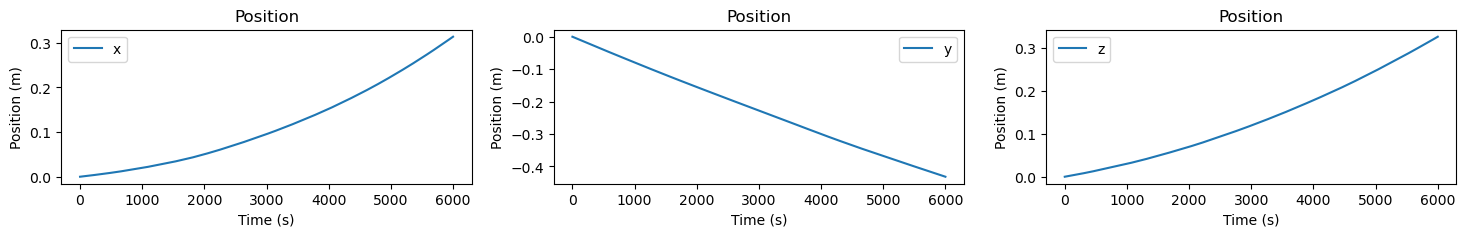

In [8]:
plt.figure(figsize=(18,2))
plt.subplot(131)
plt.plot(np.array(pos_log)[:,0]-sensor_data.iloc[:,1].values[:6000], label='x')
# plt.plot(sensor_data.iloc[:,1].values, label='true x')
plt.title('Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.subplot(132)
plt.plot(np.array(pos_log)[:,1]-sensor_data.iloc[:,2].values[:6000], label='y')
# plt.plot(sensor_data.iloc[:,2].values, label='true y')
plt.title('Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.subplot(133)
plt.plot(np.array(pos_log)[:,2]-sensor_data.iloc[:,3].values[:6000], label='z')
# plt.plot(sensor_data.iloc[:,3].values, label='true z')
plt.title('Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()


6000


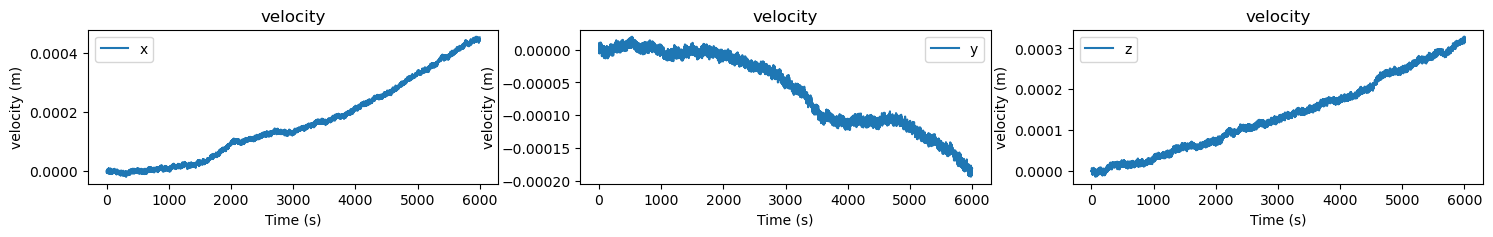

In [9]:
print(len((v_log)))
plt.figure(figsize=(18,2))
plt.subplot(131)
plt.plot(np.array(v_log)[:,0]-sensor_data.iloc[:,4].values[:6000], label='x')
# plt.plot(sensor_data.iloc[:,1].values, label='true x')
plt.title('velocity')
plt.xlabel('Time (s)')
plt.ylabel('velocity (m)')
plt.legend()
plt.subplot(132)
plt.plot(np.array(v_log)[:,1]-sensor_data.iloc[:,5].values[:6000], label='y')
# plt.plot(sensor_data.iloc[:,2].values, label='true y')
plt.title('velocity')
plt.xlabel('Time (s)')
plt.ylabel('velocity (m)')
plt.legend()
plt.subplot(133)
plt.plot(np.array(v_log)[:,2]-sensor_data.iloc[:,6].values[:6000], label='z')
# plt.plot(sensor_data.iloc[:,3].values, label='true z')
plt.title('velocity')
plt.xlabel('Time (s)')
plt.ylabel('velocity (m)')
plt.legend()


In [10]:
np.savetxt('ins_attitude_log.csv', attitude_log, delimiter=',')
np.savetxt('ins_v_log.csv', v_log, delimiter=',')
np.savetxt('ins_pos_log.csv', pos_log, delimiter=',')
np.savetxt('ins_Q_log.csv', Q_log, delimiter=',')

# 紧组合第一种

In [12]:
from ukf import UKF

def compute_Fa(rx, ry, rz, mu):
    r_squared = rx**2 + ry**2 + rz**2
    r_inv3 = 1.0 / (r_squared ** 1.5)  # r^{-3} = 1/(r^3)
    r_inv5 = 1.0 / (r_squared ** 2.5)  # r^{-5} = 1/(r^5)
    J = np.array([
        [   mu * (3 * rx**2 * r_inv5 - r_inv3),
            mu * 3 * rx * ry * r_inv5,
            mu * 3 * rx * rz * r_inv5],
        [   mu * 3 * rx * ry * r_inv5,
            mu * (3 * ry**2 * r_inv5 - r_inv3),
            mu * 3 * ry * rz * r_inv5],
        [   mu * 3 * rx * rz * r_inv5,
            mu * 3 * ry * rz * r_inv5,
            mu * (3 * rz**2 * r_inv5 - r_inv3)]])
    return J

def iterate_x(x_in, timestep, inputs):
    '''this function is based on the x_dot and can be nonlinear as needed
    inpuuts[0] is q, provides the rotation matrix C_b^i
    imputs[1] is acc, and need to change into matrix 
    inputs[2] is postion, compute the gravity
    \begin{aligned}&f_{14}=-\frac{\mu_{m}}{r^{3}}\left(1-3\frac{x^{2}}{r^{2}}\right),f_{15}=3\frac{\mu_{m}}{r^{3}}\frac{x\left(y+R_{e}\right)}{r^{2}}\\&f_{16}=3\frac{\mu_{m}}{r^{3}}\frac{xz}{r^{2}},f_{24}=f_{15}\\&f_{25}=-\frac{\mu_{m}}{r^{3}}\left(1-3\frac{\left(y+R_{e}\right)^{2}}{r^{2}}\right),f_{26}=-3\frac{\mu_{m}}{r^{3}}\left(1-3\frac{\left(y+R_{e}\right)z}{r^{2}}\right)\\&f_{34}=f_{16},f_{35}=f_{26}\\&f_{36}=-\frac{\mu_{m}}{r^{3}}\left(1-3\frac{z^{2}}{r^{2}}\right),r=\sqrt{x^{2}+\left(y+R_{e}\right)^{2}+z^{2}}\end{aligned}
    '''
    q_ = inputs[0]
    acc = inputs[1]
    ax, ay, az = acc
    pos = inputs[2]
    x, y, z = np.array(pos)*1000
    mu_m = 3.986004418e14
    R_e = 6378137
    q0, q1, q2, q3 = q_
    C_bi= np.array([[q3**2+q0**2-q1**2-q2**2, 2*q3*q2+2*q0*q1,     -2*q3*q1+2*q0*q2],
                    [-2*q3*q2+2*q0*q1,    q3**2-q0**2+q1**2-q2**2, 2*q3*q0+2*q1*q2],
                    [2*q3*q1+2*q0*q2,     -2*q3*q0+2*q1*q2,    q3**2-q0**2-q1**2+q2**2]]).T
    F_b = np.array([[0, az, -ay],[-az, 0, ax],[ay, -ax, 0]])

    r_squared = x**2 + (y + R_e)**2 + z**2
    r = np.sqrt(r_squared)
    mu_over_r3 = mu_m / (r ** 3)  # μ/r³
    inv_r_squared = 1.0 / r_squared  # 1/r²

    F_a = compute_Fa(x, y , z, mu_m)

    #X = [\Phi, \delta v, \delta pos, \epsilon, \nabla]
    Phi = x_in[0:3]
    delta_v = x_in[3:6]
    delta_pos = x_in[6:9]
    epsilon = x_in[9:12]
    nabla = x_in[12:15]

    ret = np.zeros(len(x_in))
    ret[0:3] = np.dot(C_bi, epsilon)
    ret[3:6] = (np.dot(F_b, Phi) + np.dot(F_a, delta_pos) + np.dot(C_bi, nabla))/1000
    ret[6:9] = delta_v
    ret[9:12] = np.zeros(3)
    ret[12:15] = np.zeros(3)

    return ret

def get_C_bi(q):
  q = np.array(q)
  if q[3] < 0:
    q = -q
  q0, q1, q2, q3 = q
  Msi = np.array([[q3**2+q0**2-q1**2-q2**2, 2*q3*q2+2*q0*q1,     -2*q3*q1+2*q0*q2],
                  [-2*q3*q2+2*q0*q1,    q3**2-q0**2+q1**2-q2**2, 2*q3*q0+2*q1*q2],
                  [2*q3*q1+2*q0*q2,     -2*q3*q0+2*q1*q2,    q3**2-q0**2-q1**2+q2**2]])
  return Msi.T

def get_attitude_angle(q):
  q0, q1, q2, q3 = q
  phi = np.arcsin(2*(q0*q1+q2*q3))
  psi = -np.arctan2(2*(q1*q3-q0*q2), q0**2-q1**2-q2**2+q3**2)
  gamma = -np.arctan2(2*(-q0*q3+q1*q2), q0**2-q1**2+q2**2-q3**2)
  return np.array([phi,psi,gamma])

def quest(b,r):
  '''基于星敏感器矢量观测的微小卫星姿态确定算法研究 南理工硕士
  观测矢量b，惯性系下r，有b=C_ib*r
  \sigma=\sum a_ib_i^Tr_i，a_i为加权系数，和为1
  B = \sum a_ib_ir_i^T
  S = B+B^T
  z=[B_23-B_32, B_31-B_13, B_12-B_21]^T
  g=[(1+sigma)I-S]^{-1}z
  '''
  sigma = 0
  B = np.zeros((3,3))
  n = b.shape[0]
  for i in range(n):
    bi = b[i].reshape(3,1)
    ri = r[i].reshape(3,1)
    sigma += (bi.T @ ri /n)[0][0]
    B += bi @ (ri.T) /n
  S = B + B.T
  z = np.array([[B[1,2]-B[2,1]], [B[2,0]-B[0,2]], [B[0,1]-B[1,0]]])
  g = np.eye(3)*(1+sigma) - S
  g = np.linalg.inv(g) @ z
  g_ = np.ones((4,1))
  # g_[1:] = g  #??
  g_[:-1] = g
  q = g_ / np.linalg.norm(g_)
  q = q.flatten()
  # return np.array([q[2],-q[1],q[0],-q[3]])
  return q

def skew_4(v):
  x,y,z = v
  return np.array([[0,-x,-y,-z],[x,0,z,-y],[y,-z,0,x],[z,y,-x,0]])

def picard(Q, delta_A):
  delta_theta = skew_4(delta_A)
  delta_A_mod = np.linalg.norm(delta_A)
  update_Q = np.eye(4)*np.cos(delta_A_mod/2) + delta_theta*np.sin(delta_A_mod/2)/delta_A_mod
  # 唉没办法
  update_Q[1,:] = update_Q[1,:]
  update_Q[3,:] = update_Q[3,:]
  return update_Q @ Q

def j2_perturbation_acceleration(r, mu=3.986004418e14, J2=1.08262668e-3, Re=6378137):
    rx, ry, rz = r
    r_norm = np.linalg.norm(r)  # 位置矢量模
    # 计算公共项
    re_over_r = Re / r_norm
    re_over_r_sq = re_over_r**2
    rz_over_r = rz / r_norm
    rz_over_r_sq = rz_over_r**2
    # J2修正因子（注意x/y与z分量的差异）
    factor_xy = 1 + (3/2) * J2 * re_over_r_sq * (1 - 5 * rz_over_r_sq)
    factor_z  = 1 + (3/2) * J2 * re_over_r_sq * (3 - 5 * rz_over_r_sq)
    #加速度计算
    scale = -mu/(r_norm**3)
    ax = scale * factor_xy * rx
    ay = scale * factor_xy * ry
    az = scale * factor_z  * rz
    
    return np.array([ax, ay, az])

def least_squares(A, b):
    # 使用SVD分解求解最小二乘问题
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    L_flat = Vt.T @ np.diag(1/s) @ U.T @ b
    return L_flat

def cns_get_direction_vector(debris,star):
    n_debris = debris.shape[0]
    n_star = star.shape[0]
    L = []
    R = []
    for i in range(n_debris):
        S = []
        cos = []
        debris_u, debris_v = debris.iloc[i][['u','v']].astype(float).values
        debris_uv = np.array([(debris_u)*0.000006,(debris_v)*0.000006,0.01413])
        debris_vec = debris.iloc[i][['x','y','z']].astype(float).values
        for j in range(n_star):
            star_vec = star.iloc[j][['x','y','z']].astype(float).values
            star_vec = np.array(star_vec)
            star_u, star_v = star.iloc[j][['u','v']].astype(float).values
            star_uv = np.array([(star_u)*0.000006,(star_v)*0.000006,0.01413])
            cos_angle = np.dot(star_uv,debris_uv)/(np.linalg.norm(star_uv)*np.linalg.norm(debris_uv))
            # print(star_uv,debris_uv,cos_angle)
            S.append(star_vec)
            cos.append(cos_angle)
        L0 = least_squares(np.array(S),np.array(cos))
        # print(S)
        L.append(L0)
        R.append(debris_vec)
    return np.array(L),np.array(R)

def get_Ac(n,L):
    matrix = np.zeros((int(3*n*(n-1)/2),n))
    count = 0
    for i in range(n):
        for j in range(i+1, n):
            matrix[3*count:3*count+3,i] = list(L[i])
            matrix[3*count:3*count+3,j] = [-x for x in L[j]]
            count += 1
    return matrix
def get_delta_R(n,R):
    matrix = np.zeros((int(3*n*(n-1)/2)))
    count = 0
    for i in range(n):
        for j in range(i+1, n):
            matrix[3*count:3*count+3] = R[j]-R[i]
            count += 1
    return matrix
def get_position(R,L,rho):
    position = []
    for i in range(len(R)):
        position.append(R[i]+rho[i]*L[i])
    return np.array(position)

def ins_measure(time0, last_Q, last_pos, last_v, imu_data_i):
  ''' 
  input: timestamp, last_staste
  source: imu_data
  output: attitude and position
  '''
  C_bi= get_C_bi(last_Q)
  wb = np.array(imu_data_i[4:]).astype(float)
  delta_A = C_bi.T @ np.deg2rad(wb*0.1)
  new_Q = picard(last_Q, delta_A)
  attitude_angle = get_attitude_angle(new_Q)
  acc = np.array(imu_data_i[1:4]).astype(float)
  acc_i = C_bi.T @ acc
  gi = j2_perturbation_acceleration(np.array(last_pos)*1000)
  acc_i = (acc_i + gi)/1000
  new_v = last_v + acc_i*delta_time
  new_pos = last_pos + new_v*delta_time + 0.5*acc_i*delta_time**2
  return new_pos, attitude_angle, new_v, new_Q

def cns_meaasure0(time0, last_Q, last_pos, star_table, debris_table):
  f = 0.01413
  dh = 0.000006
  dv = 0.000006
  H = 700
  b = np.array(star_table.loc[:, ['u', 'v']].values)
  r = np.array(star_table.loc[:, ['x', 'y', 'z']].values)
  b = np.append((b)*dh, np.ones((b.shape[0], 1))*f, axis=1)
  b = b/np.linalg.norm(b, axis=1).reshape(-1, 1)
  q = quest(b, r)
  attitude_angle = get_attitude_angle(q)
  return last_pos, attitude_angle, q

def cns_meaasure1(time0, last_Q, last_pos, star_table, debris_table):
  '''
   input timestamp, last_state 
   source: star_table and debris_table. star_table is dataframe, colums=[u,v,x,y,z]
   output: attitude and position
  '''
  f = 0.01413
  dh = 0.000006
  dv = 0.000006
  H = 700
  b = np.array(star_table.loc[:, ['u', 'v']].values)
  r = np.array(star_table.loc[:, ['x', 'y', 'z']].values)
  b = np.append((b)*dh, np.ones((b.shape[0], 1))*f, axis=1)
  b = b/np.linalg.norm(b, axis=1).reshape(-1, 1)
  q = quest(b, r)
  attitude_angle = get_attitude_angle(q)
  L,R = cns_get_direction_vector(debris_table, star_table)
  # if L.shape[0] != 1:
  #   print('only one debris!')
  L = L[0]
  R = R[0]
  print(L,R)

  last_pos = np.array(last_pos)
  rho = np.linalg.norm(R-last_pos)
  last_pos_ = sensor_data.iloc[time_list.index(time0)][1:4].values+np.random.randn(3)*0
  #rho = np.linalg.norm(R - last_pos_)
  new_pos1 = R - rho*L

  a1=0.2
  a2=0.8
  new_pos = (a1*last_pos+a2*R)/(a1+a2) + a2/(a1+a2)*np.inner(last_pos_-R,L)*L
  b1=1
  b2=0
  new_pos = b1*new_pos1 + b2*new_pos

  return new_pos, attitude_angle, q

def cns_meaasure2(time0, last_Q, last_pos, star_table, debris_table):
  '''
   input timestamp, last_state 
   source: star_table and debris_table. star_table is dataframe, colums=[u,v,x,y,z]
   output: attitude and position
  '''
  f = 0.01413
  dh = 0.000006
  dv = 0.000006
  H = 700
  b = np.array(star_table.loc[:, ['u', 'v']].values)
  r = np.array(star_table.loc[:, ['x', 'y', 'z']].values)
  b = np.append((b)*dh, np.ones((b.shape[0], 1))*f, axis=1)
  b = b/np.linalg.norm(b, axis=1).reshape(-1, 1)
  q = quest(b, r)
  attitude_angle = get_attitude_angle(q)
  L,R = cns_get_direction_vector(debris_table, star_table)
  n = L.shape[0]
  Ac = get_Ac(n,L)
  delta_R = get_delta_R(n,R)
  rho = least_squares(Ac,delta_R)
  position = get_position(R,L,rho)
  new_pos = position.mean(axis=0)
  return new_pos, attitude_angle, q

def cns_meaasureq(time0, last_Q, last_pos, star_table, debris_table):
  f = 0.01413
  dh = 0.000006
  dv = 0.000006
  H = 700
  b = np.array(star_table.loc[:, ['u', 'v']].values)
  r = np.array(star_table.loc[:, ['x', 'y', 'z']].values)
  b = np.append((b)*dh, np.ones((b.shape[0], 1))*f, axis=1)
  b = b/np.linalg.norm(b, axis=1).reshape(-1, 1)
  q = quest(b, r)
  attitude_angle = get_attitude_angle(q)
  return attitude_angle, q

# Process noise covariance matrix
# noise_q = np.diag([])
noise_q = np.eye(15)*0.1

# Measurement noise covariance matrix
# noise_r = np.diag([])
noise_r = np.eye(15)*0.01
noise_attitude = np.eye(3)*0.001
noise_pos = np.eye(3)*0.01
noise_acc = np.eye(3)*0.01

initial_state = np.zeros(15)

state_estimator = UKF(15,noise_q,initial_state, 0.01*np.eye(15), 0.04, 0.0, 2.0, iterate_x)


start = 1
end = len(imu_data)-1
initial_Q =sensor_data.iloc[start][['q1','q2','q3','q4']].values.tolist()
initial_pos = sensor_data.iloc[start][1:4].values.tolist()
initial_v = sensor_data.iloc[start][4:7].values.tolist()
last_Q = initial_Q
last_pos = initial_pos
last_v = initial_v
Q_log = [last_Q]
pos_log = [initial_pos]
v_log = [initial_v]
n_log = []
delta_time = 0.1


for i in range(start,end):#len(imu_data))
  inputs = []
  inputs.append(last_Q)
  inputs.append(np.array(imu_data.iloc[i][1:4]).astype(float))
  inputs.append(last_pos)
  state_estimator.predict(delta_time, inputs)

  time_i = imu_data.iloc[i][0]
  star_table = visible_star[visible_star['time'] == time_i]
  star_table = star_table.reset_index(drop=True)
  debris_table = visible_debris[visible_debris['time'] == time_i]
  debris_table = debris_table.reset_index(drop=True)
  star_table['u'] += np.random.randn(star_table.shape[0])*0.12
  star_table['v'] += np.random.randn(star_table.shape[0])*0.12
  debris_table['u'] += np.random.randn(debris_table.shape[0])*0.12
  debris_table['v'] += np.random.randn(debris_table.shape[0])*0.12
  ins_pos, ins_attitude, ins_v, ins_Q = ins_measure(time_i, last_Q, last_pos, last_v, imu_data.iloc[i])
  n_debris = debris_table.shape[0]
  if n_debris == 0 :
    cns_attitude, last_Q_ = cns_meaasureq(time_i, last_Q, last_pos, star_table, debris_table)
    last_Q =  last_Q_
    last_v = ins_v
    last_pos = ins_pos
    last_attitude = cns_attitude
    Q_log.append(last_Q)
    pos_log.append(ins_pos)
    v_log.append(ins_v)
    n_log.append(0)
    print(i,n_debris, sensor_data.iloc[i+1][1:4].values, ins_pos,cns_pos, last_pos)
    continue
  if n_debris == 1:
    cns_pos, cns_attitude, last_Q_ = cns_meaasure1(time_i, last_Q, ins_pos, star_table, debris_table)
  if n_debris > 1:
    cns_pos, cns_attitude, last_Q_ = cns_meaasure2(time_i, last_Q, last_pos, star_table, debris_table)
    if np.linalg.norm(cns_pos-last_pos) > 2:
       last_pos = cns_pos

  acc = np.array(imu_data.iloc[i][1:4]).astype(float)
  delta_attitude = ins_attitude - cns_attitude
  delta_pos = ins_pos - cns_pos

  Cbp = get_C_bi(ins_Q)
  Cnb = get_C_bi(last_Q_).T 
  Cnp = Cbp @ Cnb
  delta_attitude =np.deg2rad(np.array([Cnp[1,2],Cnp[2,0],Cnp[0,1]]))

  state_estimator.update([0,1,2], delta_attitude, noise_attitude)
  state_estimator.update([6,7,8], delta_pos, noise_pos)
  state_estimator.update([12,13,14], acc, noise_acc)
  
  new_state = state_estimator.get_state()
  #print(i,new_state)
  if new_state[0:3].all()!=0:
    last_Q = picard(ins_Q, new_state[0:3])
  last_v = ins_v 
  last_pos = ins_pos - new_state[6:9]
  last_attitude = get_attitude_angle(last_Q)
    
  Q_log.append(last_Q_)
  pos_log.append(last_pos)
  v_log.append(last_v)
  n_log.append(n_debris)

  print(new_state)
  #print(last_Q, sensor_data.iloc[i][['q1','q2','q3','q4']].values)
  print(i,n_debris, sensor_data.iloc[i][1:4].values, ins_pos,cns_pos, last_pos)
  print(last_v, sensor_data.iloc[i][4:7].values)

[-0.78255094 -0.48146686 -0.39470716] [-3787.510475  4780.275379 -3298.97518 ]
[-1.88021746e-06 -3.23127697e-06 -1.66170429e-06  0.00000000e+00
  5.42101086e-20  5.42101086e-20 -5.18179784e-02  2.84125350e-01
 -2.16809082e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.07278876e-02 -7.33456256e-03  2.49602429e-02]
1 1 [-1260.405927 6335.469087 -2024.457639] [-1260.96913106  6335.21169145 -2024.91097097] [-1260.89140409  6334.78550342 -2024.58575735] [-1260.91731308  6334.9275661  -2024.69416189]
[-5.63212038 -2.5735457  -4.5334498 ] [-5.63228 -2.572726 -4.53371]
[-0.78263249 -0.48164036 -0.39434656] [-3788.079393  4780.160505 -3298.487487]
[-3.89402093e-06 -5.00320653e-06 -1.91374769e-06 -2.11133779e-05
 -1.75950295e-05 -6.04285472e-06  4.38103766e-02 -2.30533170e-01
  1.93869941e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.28199116e-02 -8.67816150e-03 -7.71868549e-03]
2 1 [-1260.969147 6335.211774 -2024.910997] [-1261.48050109  6334.67008996 -2025.14746797] [-1261.5

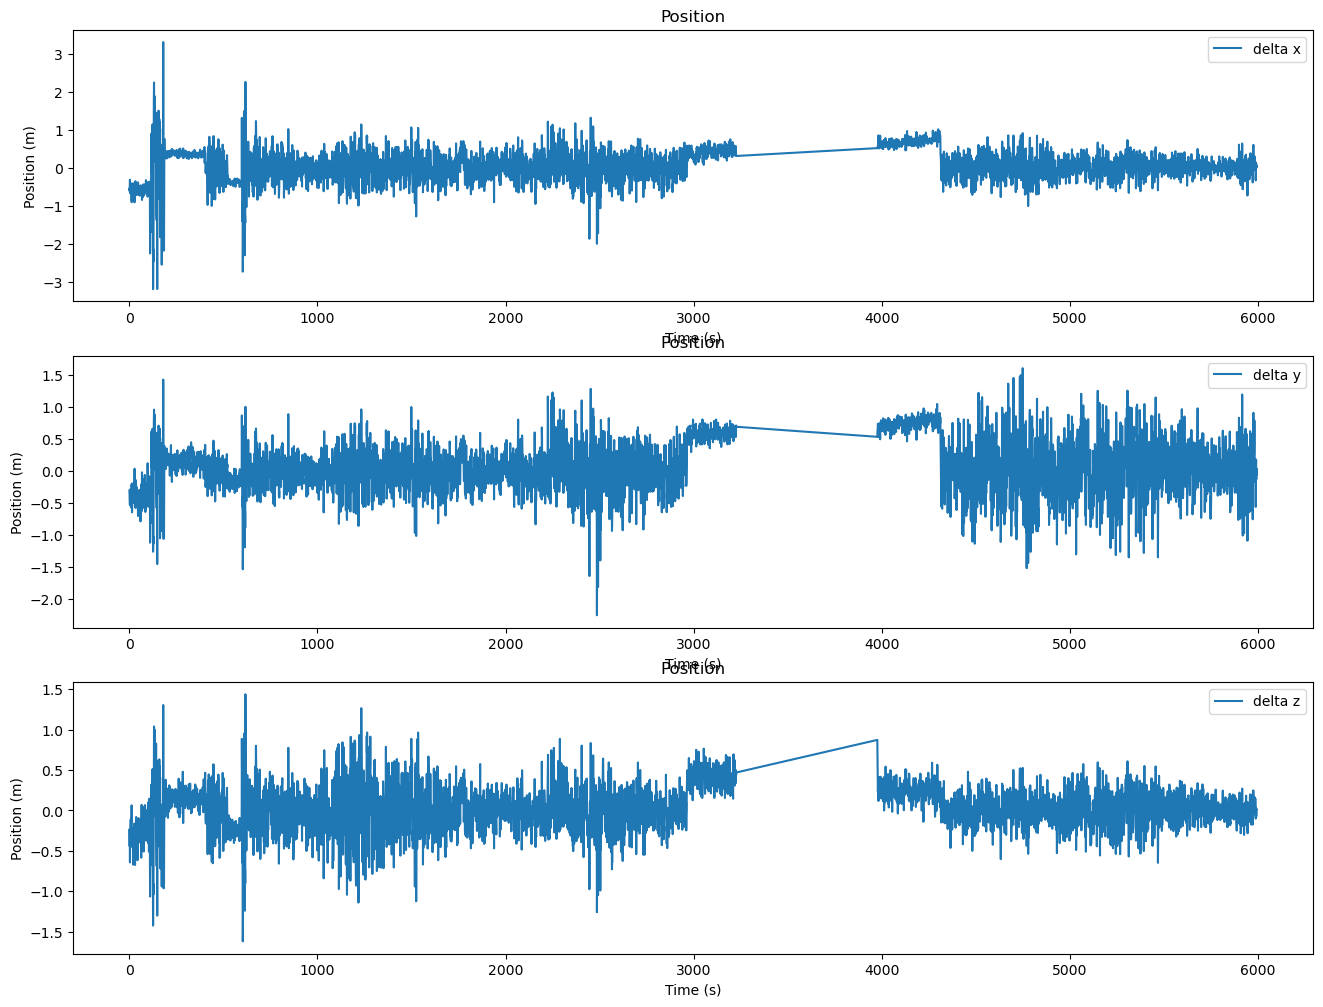

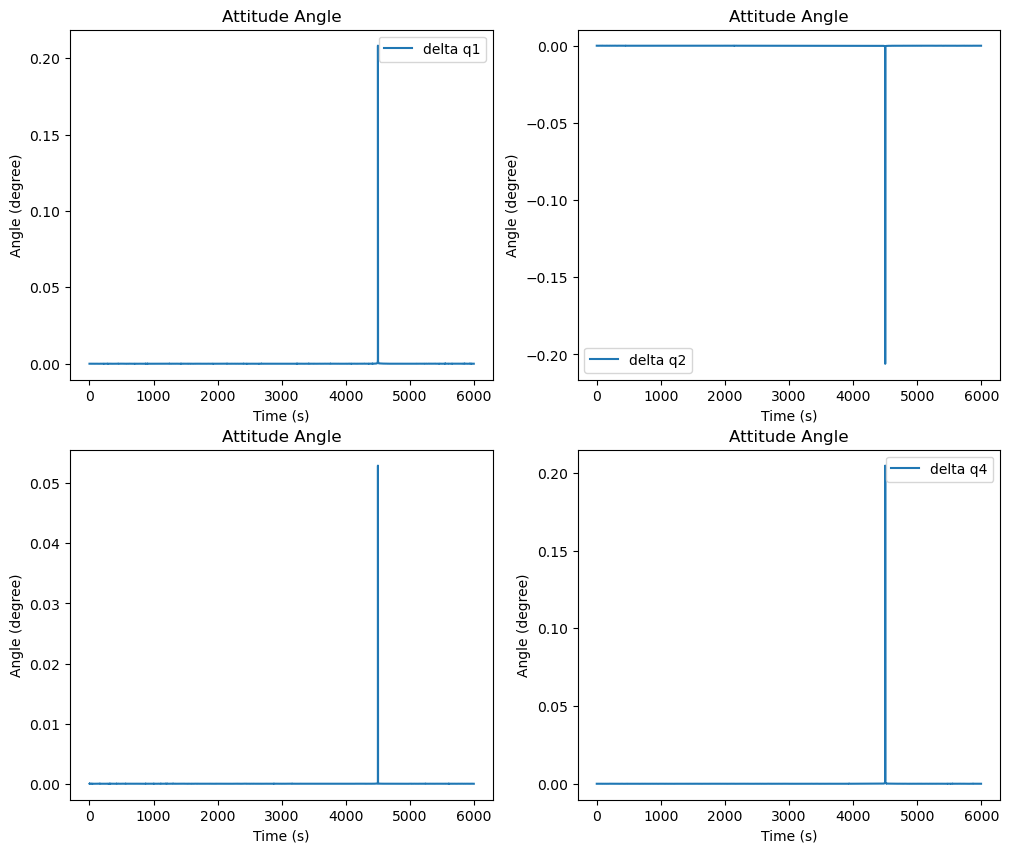

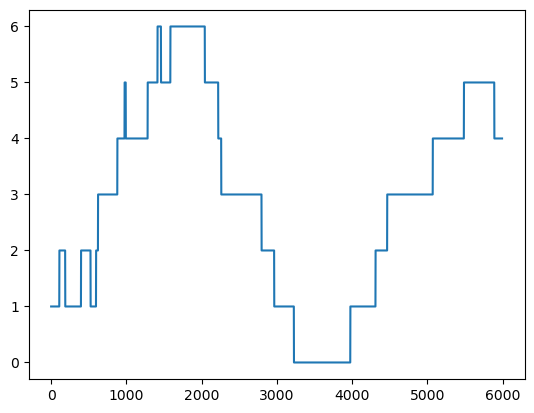

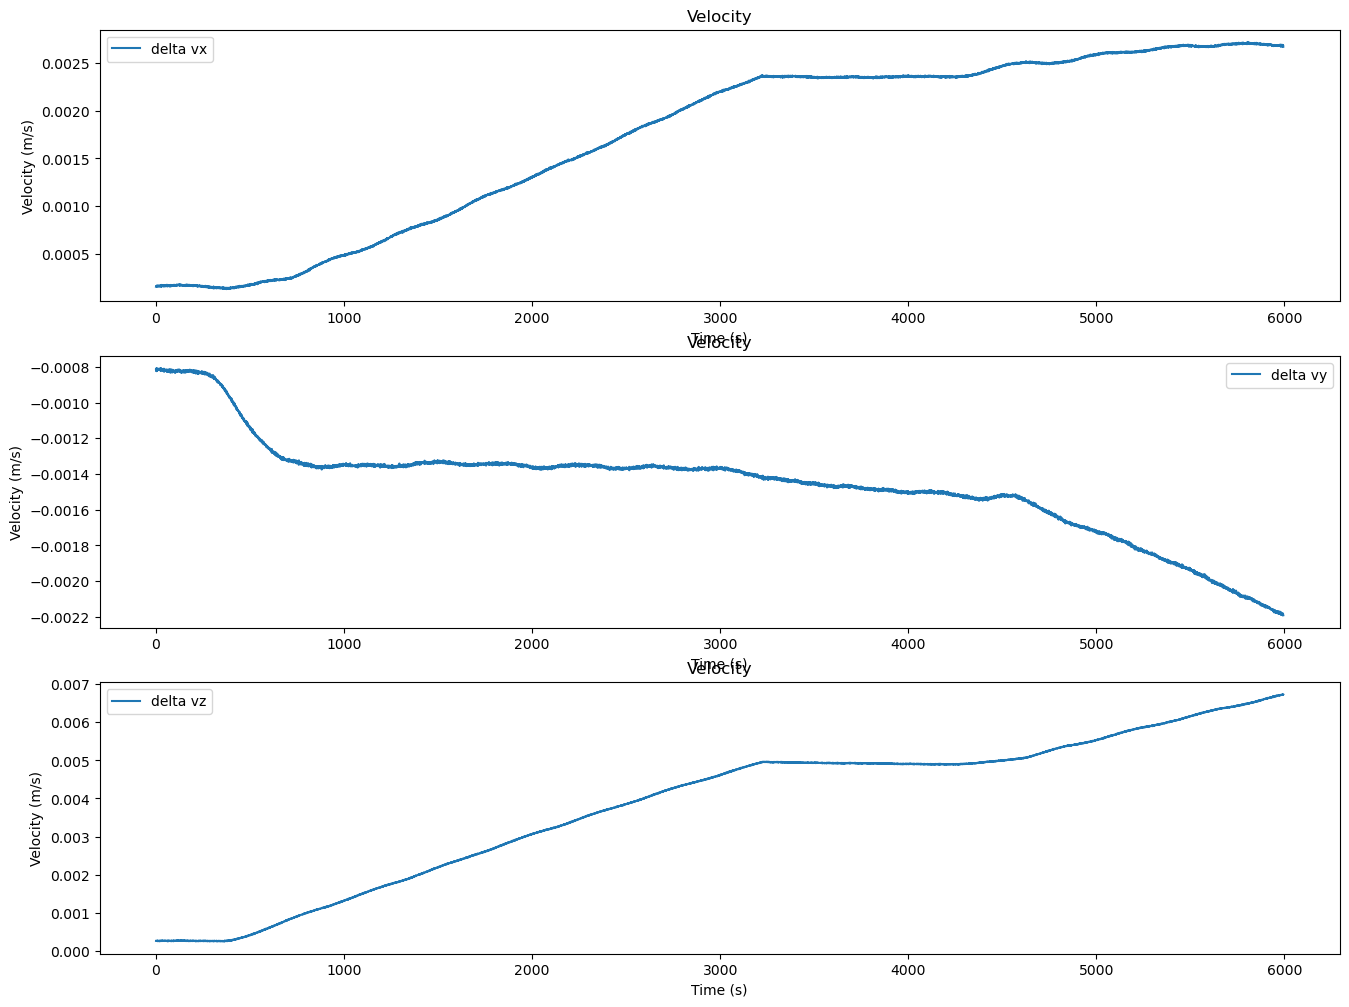

In [13]:
#画图.
pos_log = np.array(pos_log)
true_pos = np.array(sensor_data.iloc[start-1:end-1,1:4].values)
start_plt = 2
end_plt = end-start
plt.figure(figsize=(16,12))
plt.subplot(311)
plt.plot(pos_log[start_plt:end_plt,0]-true_pos[start_plt:end_plt,0], label='delta x')
plt.title('Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.subplot(312)
plt.plot(pos_log[start_plt:end_plt,1]-true_pos[start_plt:end_plt,1], label='delta y')
plt.title('Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.subplot(313)
plt.plot(pos_log[start_plt:end_plt,2]-true_pos[start_plt:end_plt,2], label='delta z')
plt.title('Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()

Q_log = np.array(Q_log)
true_Q = np.array(sensor_data.iloc[start-1:end-1][['q1','q2','q3','q4']].values)
for i in range(len(true_Q)):
  if true_Q[i][3] <= 0:
    true_Q[i] = -true_Q[i]
true_Q[4501] = -true_Q[4501]
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.plot(Q_log[start_plt:end_plt,0]-true_Q[start_plt:end_plt,0], label='delta q1')
plt.title('Attitude Angle')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degree)')
plt.legend()
plt.subplot(222)
plt.plot(Q_log[start_plt:end_plt,1]-true_Q[start_plt:end_plt,1], label='delta q2')
plt.title('Attitude Angle')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degree)')
plt.legend()
plt.subplot(223)
plt.plot(Q_log[start_plt:end_plt,2]-true_Q[start_plt:end_plt,2], label='delta q3')
plt.title('Attitude Angle')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degree)')
plt.subplot(224)
plt.plot(Q_log[start_plt:end_plt,3]-true_Q[start_plt:end_plt,3], label='delta q4')
plt.title('Attitude Angle')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degree)')
plt.legend()
plt.figure()
plt.plot(n_log[start_plt:end_plt])

v_log = np.array(v_log)
true_v = np.array(sensor_data.iloc[start-1:end-1,4:7].values)
plt.figure(figsize=(16,12))
plt.subplot(311)
plt.plot(v_log[start_plt:end_plt,0]-true_v[start_plt:end_plt,0], label='delta vx')
plt.title('Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.subplot(312)
plt.plot(v_log[start_plt:end_plt,1]-true_v[start_plt:end_plt,1], label='delta vy')
plt.title('Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.subplot(313)
plt.plot(v_log[start_plt:end_plt,2]-true_v[start_plt:end_plt,2], label='delta vz')
plt.title('Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()




In [ ]:
print(Q_log[4502])
print(true_Q[4502])

[ 0.49250874  0.66514794 -0.56125399  0.00270541]
[ 4.89380e-01  6.67275e-01 -5.61472e-01  3.70000e-05]


In [14]:
#savedata
np.savetxt('Q_log.txt', Q_log)
np.savetxt('pos_log.txt', pos_log)
np.savetxt('v_log.txt', v_log)
np.savetxt('n_log.txt', n_log)
np.savetxt('attitude_log.txt', attitude_log)


In [ ]:
print(sensor_data)

                 Time (UTCG)       x (km)       y (km)       z (km)  \
0    2023-04-25 16:00:00.000 -1259.842691  6335.726319 -2024.004255   
1    2023-04-25 16:00:00.100 -1260.405927  6335.469087 -2024.457639   
2    2023-04-25 16:00:00.200 -1260.969147  6335.211774 -2024.910997   
3    2023-04-25 16:00:00.300 -1261.532351  6334.954379 -2025.364329   
4    2023-04-25 16:00:00.400 -1262.095539  6334.696903 -2025.817635   
...                      ...          ...          ...          ...   
5996 2023-04-25 16:09:59.600 -4102.844515  3501.379063 -4088.077014   
5997 2023-04-25 16:09:59.700 -4103.192717  3500.727468 -4088.285328   
5998 2023-04-25 16:09:59.800 -4103.540866  3500.075827 -4088.493588   
5999 2023-04-25 16:09:59.900 -4103.888963  3499.424142 -4088.701797   
6000 2023-04-25 16:10:00.000 -4104.237006  3498.772412 -4088.909952   

      Velocity x (km/sec)  Velocity y (km/sec)  Velocity z (km/sec)        q1  \
0               -5.632442            -2.571912            -4.53397